<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'Flex Kr Map' Study</p><br>

# Prepares a Kr map for F100

In [132]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [242]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range
from invisible_cities.core.core_functions import shift_to_bin_centers


In [580]:
from dataclasses import dataclass
from typing                import Tuple
from invisible_cities.core import fit_functions as fitf

In [581]:
def profile1d(z : np.array,
              e : np.array,
              nbins_z : int,
              range_z : np.array)->Tuple[float, float, float]:
    """Adds an extra layer to profileX, returning only valid points"""
    x, y, yu     = fitf.profileX(z, e, nbins_z, range_z)
    valid_points = ~np.isnan(yu)
    x    = x [valid_points]
    y    = y [valid_points]
    yu   = yu[valid_points]
    return x, y, yu

In [134]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

In [136]:
NN= -999999  # No Number, a trick to aovid nans in data structs


class NNN:

    def __getattr__(self, _):
        return NN


In [324]:
def closest_index(xa, xv):
    """Returns the index of the element in array xa closest to xv"""
    dx = np.abs(xa - xv)
    return dx.argmin()

def closest_index_test():
    xa = np.arange(10)
    xv = 5
    assert closest_index(xa, xv) == 5
    
       

In [720]:
@dataclass
class RMap:
    """histogram map"""
    R  : np.array
    e : np.array
        
    def map_i(self, r):
        """Return the ir coordinates in map corresponding to the location R"""
        return closest_index(self.R, r)

    def cr(self, r):
        """Return the correction in map corresponding to the location R"""
        i = self.map_i(r)
        ii = np.min([i, len(self.R) -1])
        return self.e[ii]


In [620]:
def rXY(x,y):
    return np.sqrt(x**2 + y**2)

def pXY(x,y):
    return np.arctan2(y,x)
    

In [721]:
def radial_energy_correction(krdst, rmap, varx='true_x', vary='true_y', verbose=False, ic=100):
    """Takes a radial map (rmap) and corrects for the dominant radial dependences"""
    ii = 0
    CC = np.zeros(len(krdst.index))
    EC = np.zeros(len(krdst.index))
    krdf = (krdst.drop(columns=['Unnamed: 0'])).copy()
    
    print(len(CC))
    #for i in range(10):
    for i in krdst.index:
        
        evt = krdst.loc[i]
        if len(evt) == 0:
            print(f' event = {ii} number = {i} is corrupted, skipping')
            continue
            
        if ii%ic == 0 and verbose:
            print(f' event = {ii} number = {i}, x = {evt[varx]}, y = {evt[vary]}, S2e = {evt.S2e}')
    
        r = rXY(evt.true_x,evt.true_y)
        c   = rmap.cr(r)
        CC[ii] = c 
        if c > 0: 
            EC[ii] = evt.S2e/c

        if ii%ic == 0 and verbose:
            print(f' c = {c}, Ec ={EC[ii]}')
        ii+=1
    
    krdf['Ec'] = EC    
    krdf['gc'] = CC 
    
    return krdf


In [146]:
def sigma_max_true(krdst, true='true_x', var='xmax', bins=10, alpha=0.6, color='g'):
    dx = (krdst[true] - krdst[var]).values
    mu, std = norm.fit(dx)
    plt.hist(dx, bins=bins, density=True, alpha=alpha, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    

In [689]:
def plot_ec(krdst, emin=0, emax=1e+6, bins=100, alpha=0.6, color='g'):
    
    kemax = krdst[krdst.Ec<emax]
    kemin = kemax[kemax.Ec>emin]
    ec    = kemin.Ec.values
    mu, std = norm.fit(ec)
    plt.hist(ec, bins=bins, density=True, alpha=alpha, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, bins)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    print(f' sigma/E ={2.3 * 100 * std/mu} FWHM')
    plt.show()


# DATA

In [137]:
VERBOSITY = False

# Input data

In [547]:
iPATH = "/Users/jj/Development/demoData/flexkr"

In [548]:
pitch = 15.55
pitch

15.55

## SiPMs are at indices < 10000 in dataframes 

In [549]:
sipm_index = 10000

## read SiPM map

In [550]:
sipm_map = (pd.read_csv('sipm_map.csv')).drop(['Unnamed: 0'], axis='columns', inplace=True)


In [551]:
sipm_map

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,1040,TP_SiPM,15.55,-450.95,1.907349e-07,31.100000,-435.400012,-466.500012,1039,1041,1066,1019
1,1,4059,TP_SiPM,93.30,450.95,7.775000e+01,108.850003,466.500012,435.400012,4058,4060,4080,4033
2,2,3753,TP_SiPM,-62.20,326.55,-7.775000e+01,-46.650001,342.099988,310.999988,3752,3754,3799,3705
3,3,3842,TP_SiPM,-77.75,357.65,-9.330000e+01,-62.200000,373.199994,342.099994,3841,3843,3884,3798
4,4,3797,TP_SiPM,-93.30,342.10,-1.088500e+02,-77.750003,357.650006,326.550006,3796,3798,3841,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,3088,1717,TP_SiPM,311.00,-217.70,2.954500e+02,326.550000,-202.149997,-233.249997,1716,1718,1774,1661
3089,3089,2317,TP_SiPM,357.65,-62.20,3.421000e+02,373.199994,-46.650001,-77.750001,2316,2318,2380,2255
3090,3090,1676,TP_SiPM,-326.55,-217.70,-3.421000e+02,-310.999988,-202.149997,-233.249997,1675,1677,1733,1620
3091,3091,3517,TP_SiPM,186.60,248.80,1.710500e+02,202.150006,264.350003,233.250003,3516,3518,3570,3463


In [552]:
xmax = sipm_map.x.max()
xmin = sipm_map.x.min()
ymax = sipm_map.y.max()
ymin = sipm_map.y.min()
print(f'xmax = {xmax} xmin = {xmin} ymax = {ymax} ymin = {ymin}')

xmax = 482.05 xmin = -482.05 ymax = 482.05 ymin = -482.05


In [553]:
wbin = 5
bins = int((xmax - xmin)/wbin) +1

In [554]:
print(f'number of bins = {bins}')

number of bins = 193


## Krypton energy in keV

In [555]:
Ekr = 41.54
print(f'Krypton energy in keV = {Ekr}')

Krypton energy in keV = 41.54


## S1 time

In [144]:
s1_time = 1 * units.mus

In [556]:
krdst = pd.read_csv('/Users/jj/Development/demoData/flexkr/krdst.csv')

In [557]:
krdst

,Unnamed: 0,event_id,true_x,true_y,true_z,KE,S1e,S2e,xmax,ymax,xpos,ypos,qmax,ql,qr,qu,qd
0,0,358000,-109.308620,-446.557600,1181.779400,54.070770,93,62911,-108.85,-450.95,-111.130666,-449.900621,66,53,31,54,43
1,1,358001,452.681180,83.854360,366.041080,41.543297,79,62291,450.95,93.30,452.791454,89.927713,68,33,51,31,67
2,2,358002,10.379469,-38.256410,789.598700,41.543297,102,50797,15.55,-46.65,14.106072,-44.025938,65,44,31,61,34
3,3,358003,-310.724100,6.975109,418.403660,41.543297,79,53376,-311.00,-0.00,-310.424074,1.749375,74,41,47,52,34
4,4,358004,-200.281400,-248.720670,51.601925,41.543297,86,53947,-202.15,-248.80,-200.983747,-249.595172,91,47,62,38,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271495,495,227495,231.409560,-341.614040,294.327100,41.543297,89,56354,233.25,-342.10,232.035156,-341.504788,103,52,37,57,49
271496,496,227496,88.275920,450.327030,495.416440,41.543297,108,61593,93.30,450.95,90.907694,450.258896,72,69,41,50,58
271497,497,227497,70.804490,439.830380,1024.527100,41.543297,101,59916,62.20,435.40,64.378981,436.472410,63,36,58,46,36
271498,498,227498,-329.059780,311.101530,331.603180,41.543297,105,61734,-326.55,311.00,-327.364129,311.604722,87,57,47,50,43


In [558]:
krdst.loc[0]

Unnamed: 0         0.000000
event_id      358000.000000
true_x          -109.308620
true_y          -446.557600
true_z          1181.779400
KE                54.070770
S1e               93.000000
S2e            62911.000000
xmax            -108.850000
ymax            -450.950000
xpos            -111.130666
ypos            -449.900621
qmax              66.000000
ql                53.000000
qr                31.000000
qu                54.000000
qd                43.000000
Name: 0, dtype: float64

In [559]:
np.sqrt(xmax**2 + ymax**2)

681.7216477419505

In [413]:
krdst = krdst[in_range(krdst.KE, 41.5, 41.6)]

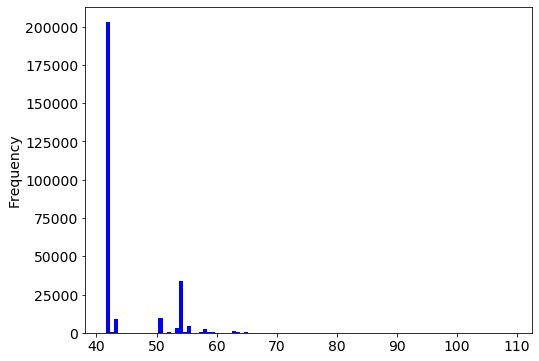

In [560]:
krdst['KE'].plot(kind='hist', bins=100, color='blue')

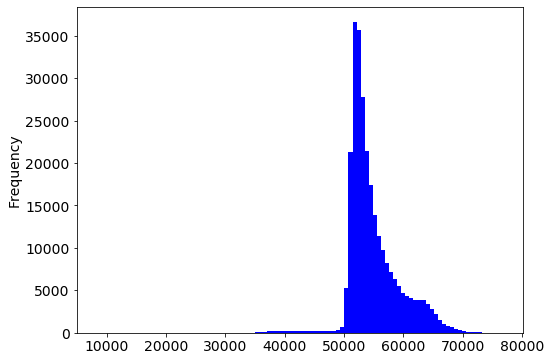

In [561]:
krdst['S2e'].plot(kind='hist', bins=100, color='blue')

In [704]:
rmax = 470

In [705]:
krfid2 = krdst[in_range(rXY(krdst.true_x,krdst.true_y), 0, rmax )]

In [706]:
krfid = krfid2[in_range(krfid2.S2e, 5e+4, 7e+4 )]

In [707]:
len(krfid)

246797

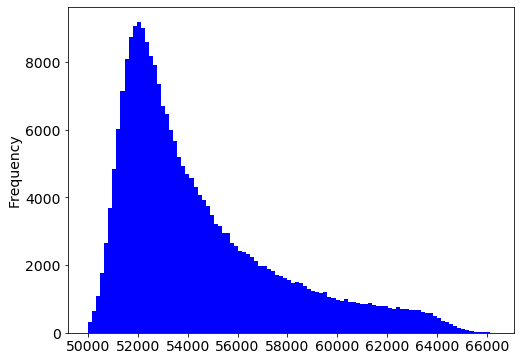

In [708]:
krfid['S2e'].plot(kind='hist', bins=100, color='blue')

In [709]:
len(krfid) / len(krdst)

0.909012891344383

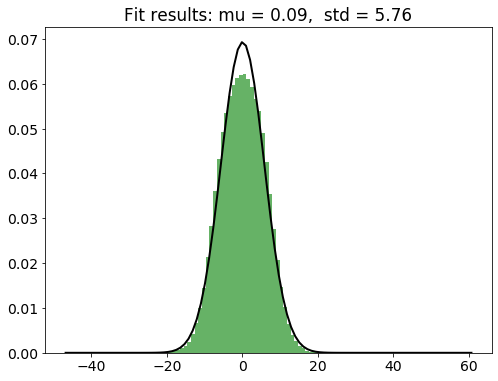

In [710]:
sigma_max_true(krfid, true='true_x', var='xmax', bins=100, alpha=0.6, color='g')

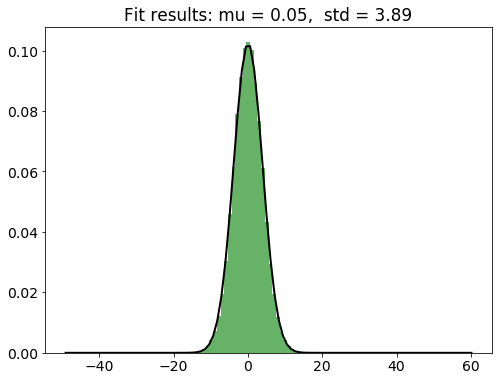

In [711]:
sigma_max_true(krfid, true='true_x', var='xpos', bins=100, alpha=0.6, color='g')

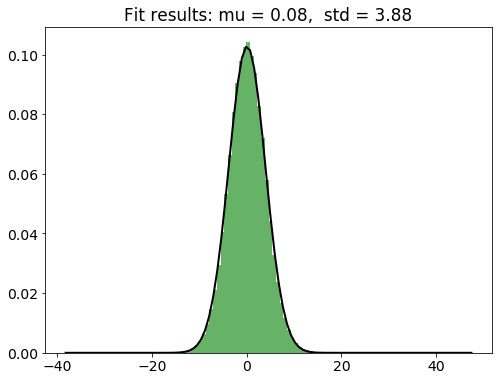

In [712]:
sigma_max_true(krfid, true='true_y', var='ypos', bins=100, alpha=0.6, color='g')

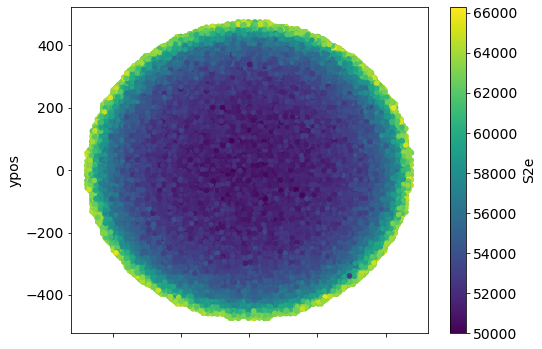

In [713]:
krfid.plot(kind='scatter', x='xpos', y='ypos', c='S2e', cmap='viridis')

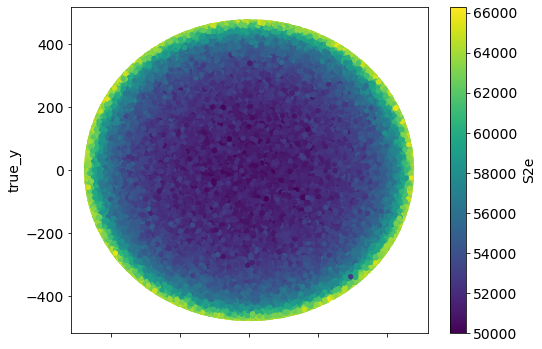

In [714]:
krfid.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

## Radial correction using true variables

In [715]:
R, e, eu = profile1d(rXY(krfid.true_x.values,krfid.true_y.values),krfid.S2e.values, 500, (0,rmax))

<ErrorbarContainer object of 3 artists>

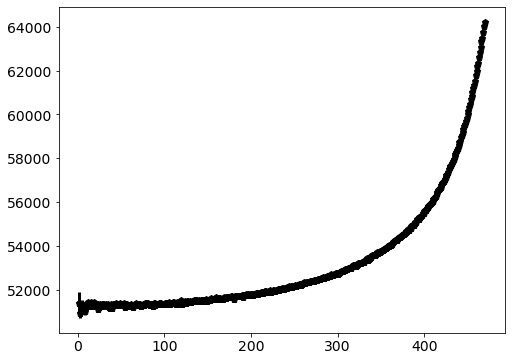

In [716]:
plt.errorbar(R, e, eu, fmt="kp", ms=7, lw=3)

In [717]:
e.min()

50944.833333333336

In [718]:
E = e / e.min()

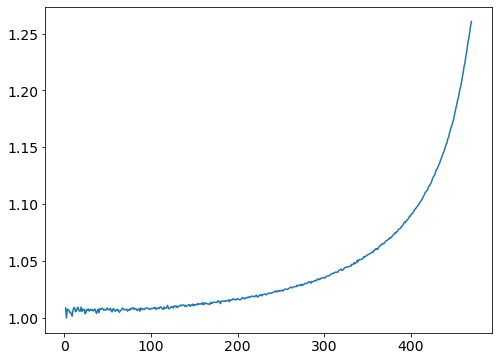

In [719]:
plt.plot(R, E)

In [722]:
rmap = RMap(R, E)

In [724]:
krdf = radial_energy_correction(krfid, rmap, varx='true_x', vary='true_y', verbose=False, ic=100)

246797


In [725]:
krdf

,event_id,true_x,true_y,true_z,KE,S1e,S2e,xmax,ymax,xpos,ypos,qmax,ql,qr,qu,qd,Ec,gc
0,358000,-109.308620,-446.557600,1181.779400,54.070770,93,62911,-108.85,-450.95,-111.130666,-449.900621,66,53,31,54,43,51717.451344,1.216437
1,358001,452.681180,83.854360,366.041080,41.543297,79,62291,450.95,93.30,452.791454,89.927713,68,33,51,31,67,51207.765918,1.216437
2,358002,10.379469,-38.256410,789.598700,41.543297,102,50797,15.55,-46.65,14.106072,-44.025938,65,44,31,61,34,50564.116919,1.004606
3,358003,-310.724100,6.975109,418.403660,41.543297,79,53376,-311.00,-0.00,-310.424074,1.749375,74,41,47,52,34,51363.111701,1.039189
4,358004,-200.281400,-248.720670,51.601925,41.543297,86,53947,-202.15,-248.80,-200.983747,-249.595172,91,47,62,38,47,51728.557696,1.042886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271495,227495,231.409560,-341.614040,294.327100,41.543297,89,56354,233.25,-342.10,232.035156,-341.504788,103,52,37,57,49,51042.654369,1.104057
271496,227496,88.275920,450.327030,495.416440,41.543297,108,61593,93.30,450.95,90.907694,450.258896,72,69,41,50,58,50790.400522,1.212690
271497,227497,70.804490,439.830380,1024.527100,41.543297,101,59916,62.20,435.40,64.378981,436.472410,63,36,58,46,36,51434.729155,1.164894
271498,227498,-329.059780,311.101530,331.603180,41.543297,105,61734,-326.55,311.00,-327.364129,311.604722,87,57,47,50,43,51986.759442,1.187495


In [726]:
phi, e, eu = profile1d(pXY(krdf.true_x.values,krdf.true_y.values),krdf.Ec.values, 500, (0,np.pi))

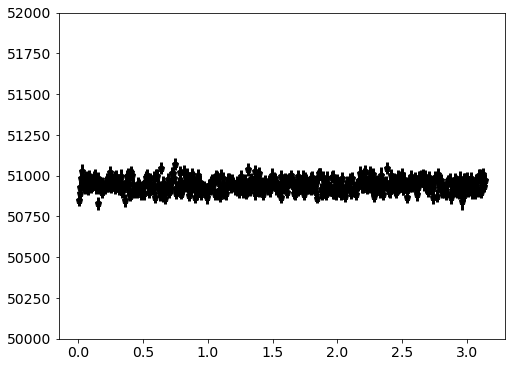

In [729]:
plt.errorbar(phi, e, eu, fmt="kp", ms=7, lw=3)
plt.ylim(50000, 52000)
plt.show()

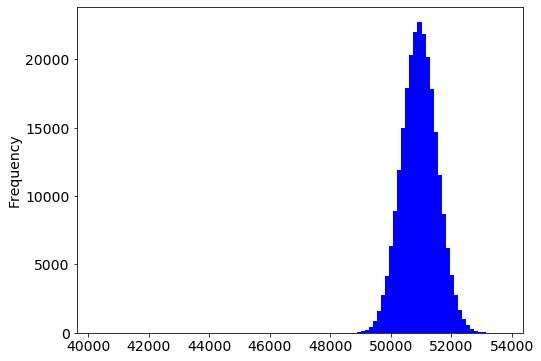

In [730]:
krdf['Ec'].plot(kind='hist', bins=100, color='blue')

 sigma/E =2.636956055060133 FWHM


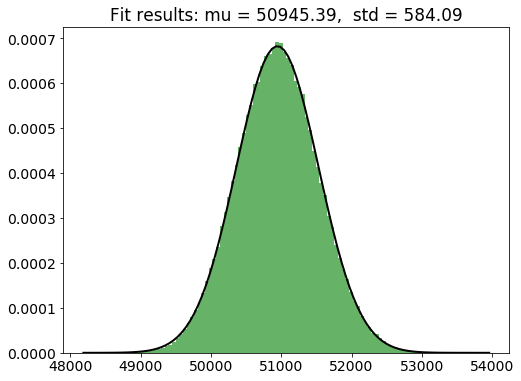

In [731]:
plot_ec(krdf, emin=48000, emax=54000, bins=100, alpha=0.6, color='g')

### Thus, when using true positions to compute corrections the resulting resolution is "Fano". Only radial corrections are needed

## Using reconstructed positions

In [736]:
R, e, eu = profile1d(rXY(krfid.xpos,krfid.ypos),krfid.S2e.values, 500, (0,rmax))

<ErrorbarContainer object of 3 artists>

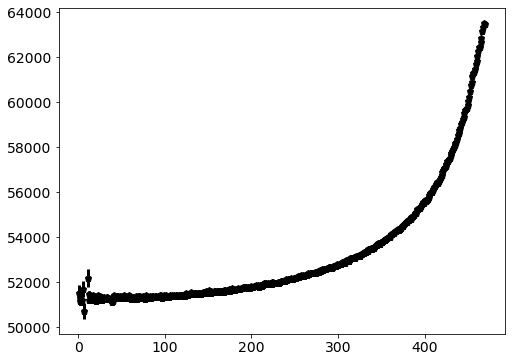

In [737]:
plt.errorbar(R, e, eu, fmt="kp", ms=7, lw=3)

In [738]:
E = e / e.min()

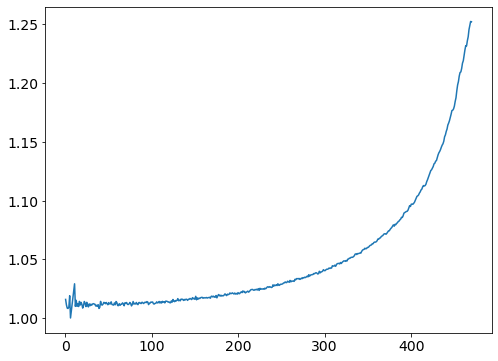

In [739]:
plt.plot(R, E)

In [740]:
rmap = RMap(R, E)

In [741]:
krdf2 = radial_energy_correction(krfid, rmap, varx='xpos', vary='ypos', verbose=False, ic=100)

246797


 sigma/E =2.6623786631301414 FWHM


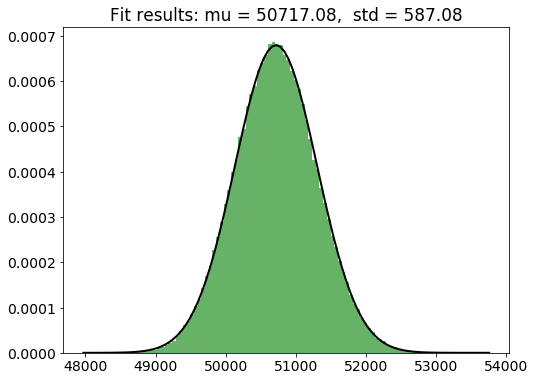

In [742]:
plot_ec(krdf2, emin=48000, emax=54000, bins=100, alpha=0.6, color='g')

### Using reconstructed positions does not alter "fano"

## S1

In [732]:
def histo_s1(kf, s1fid = 200, bins=100, alpha=0.6, color='g'):
    
    s1df = kf[kf.S1e < s1fid]
    plt.hist(s1df.S1e.values, bins=bins, density=False, alpha=alpha, color=color)
    plt.show()


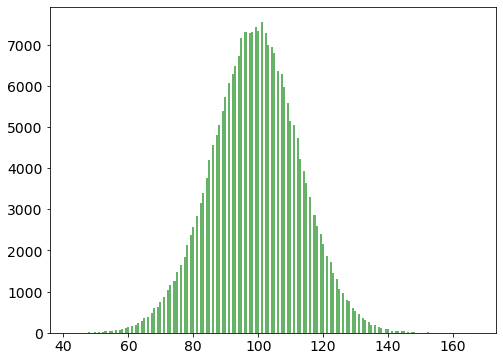

In [735]:
histo_s1(krdf, s1fid = 200, bins=200, alpha=0.6, color='g')